ENGAGE 2020 - Domino and A.I.
==========================

## The challenge - Classify images using a Convolutional Neural Network (CNN)

Classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html) Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.


### Import the required libraries

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf             # Machine Learning

from tensorflow.keras import datasets, layers, models
from tensorflow import keras
import tensorflow_datasets as tfds  # Allow for custom dataset

import matplotlib.pyplot as plt     # Visualization
import numpy as np                  # Numerical Python used for Scientific Computing

from datetime import datetime

import pathlib

import requests                     # Work with APIs

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

### Check Tensorflow and Keras version

In [ ]:
print(tf.__version__)
print(tf.keras.__version__)

### Download the CIFAR10 dataset from Domino using Project Keep

#### Retrieve token and clean it up

In [ ]:
endpoint = 'https://frascati.projectkeep.io/auth'
data = {'username':'lquirm', 'password':'Disk!@#$World0987'}
headers = {'accept': 'application/json',
           'Content-Type': 'application/json'}

response = requests.post(endpoint, headers=headers, json=data)  # use json in place of data

# Clean up the response so we can use the auth bearer later
wlist = response.text.split()
token = wlist[0].replace('{"bearer":"', "").replace('","claims":{"iss":"The', "")

#### Define the API variables, and endpoint for Project Keep

In [ ]:
api_url_base = 'https://frascati.projectkeep.io/document/'  # Endpoint for GET attachment

#Define varibles used with Project Keep attachements
keep_unid_at = '78426DA49B4B41388025851A005BA1D9'  # unique id of the folder containing attachment
keep_db = 'demo-george'  # DB
keep_filename = 'cifar-10-python.tar'   # Attachment filename

#### Verify URL for Project Keep API looks correct

In [ ]:
print(api_url_base+keep_unid_at+'/'+'$file'+'?'+'db='+keep_db+'&filename='+keep_filename)  #Verify format of GET URL

#### Set up our HTTP request header per API rules

In [ ]:
headers = {'Authorization': 'Bearer {0}'.format(token)}   # JSON payloads
print (headers)

#### Simple function to grab our dataset attachment

In [ ]:
def get_file_from_domino():
    
    # Setup a well formed GET request 
    api_url = api_url_base+keep_unid_at+'/'+'$file'+'?'+'db='+keep_db+'&filename='+keep_filename   # Attachments
    
    # Send HTTP GET request to Domino server
    response = requests.get(api_url, headers=headers)
    
    # Verify that our HTTP GET request can be served
    if response.status_code == 200:
        with open('cifar-10-python.tar', 'wb') as file:
            for chunk in response.iter_content(chunk_size=128):
                file.write(chunk)
        file.close()
        print(keep_filename, "saved successfully.")
    elif response.status_code == 400:
        print("Status code 400 received, server is rejecting our request.")
        print(response.content)
    else:
        print("Received something other than a 200 or 400 response!")
        print(response.content)

#### Let's grab our data!

In [ ]:
get_file_from_domino()   # Run our function to get our attachment and save locally

#### Input data into our testing and training buckets

In [ ]:
train_test_dataset = tf.keras.utils.get_file(origin='http://domino-with-jupyter-jupyter.app.okd.hcllabs.net/edit/cifar-10-python.tar', 
                                   fname='domino_cifar10', untar=False)

train_test_dataset = pathlib.Path(train_test_dataset)

print("Local copy of our Domino CIFAR dataset: {}".format(train_test_dataset))

# See all registered datasets
#tfds.list_builders()

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()   # backup

### Let's explore our dataset

In [ ]:
train_images.shape

In [ ]:
train_labels

In [ ]:
#plt.figure()
plt.imshow(train_images[0])  # chose image to view
plt.colorbar()  # provides pixel value
#plt.grid(False)
plt.show()
train_labels[0]  # show array int label

In [ ]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
plt.figure()
plt.imshow(train_images[0])  # chose image to view
plt.colorbar()  # provides pixel value

### Let's further inspect the dataset

View first 25 images from the training set and display the class name below each image.


In [ ]:
class_names = ['plane', 'vehicle', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'boat', 'truck']

### Confirm data is randomized

In [ ]:
plt.figure(figsize=(12,12))  # size of images below
for i in range(25):
    plt.subplot(5,5,i+1)  # give each image a plot to exist on
    plt.xticks([])  # remove pixel size listing on x-axis
    plt.yticks([])  # remove pixel size listing on y-axis
    #plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)  # place image in plot
    # The CIFAR labels are integers in an array
    plt.xlabel(class_names[train_labels[i][0]])  # assign labels to images in plot
plt.show()

### Create our Neural Network

Below we define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels).  We will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images.


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of our model so far.

In [ ]:
model.summary()

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

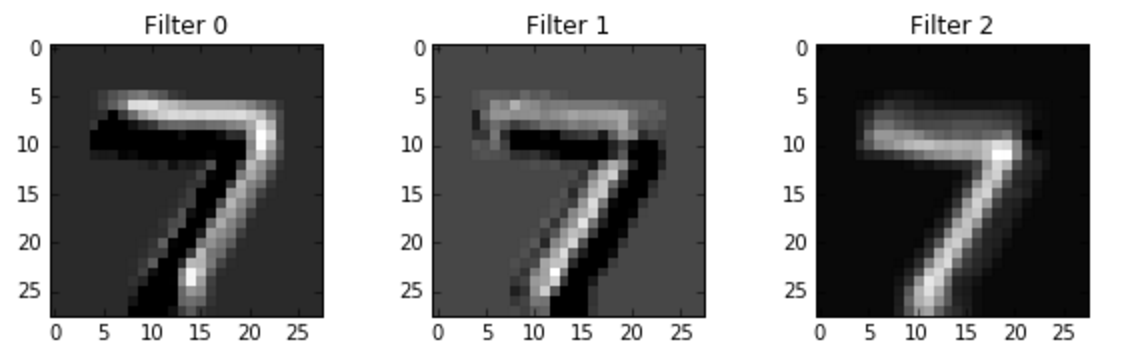

### Add Dense layers on top
Now let's add our filtered images for the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, we need to flatten the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs and a softmax activation.

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))   # rectified linear unit, type of activation function
model.add(layers.Dense(10))

Here's the complete architecture of our model.

In [ ]:
model.summary()

As you can see, our (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

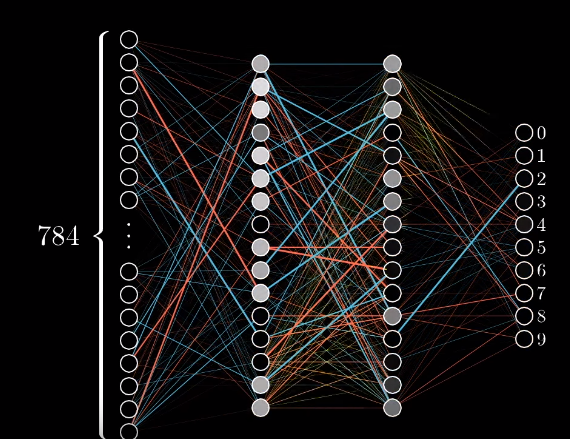

#### Tensorboard requires logging to be set

In [ ]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

### Compile our model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

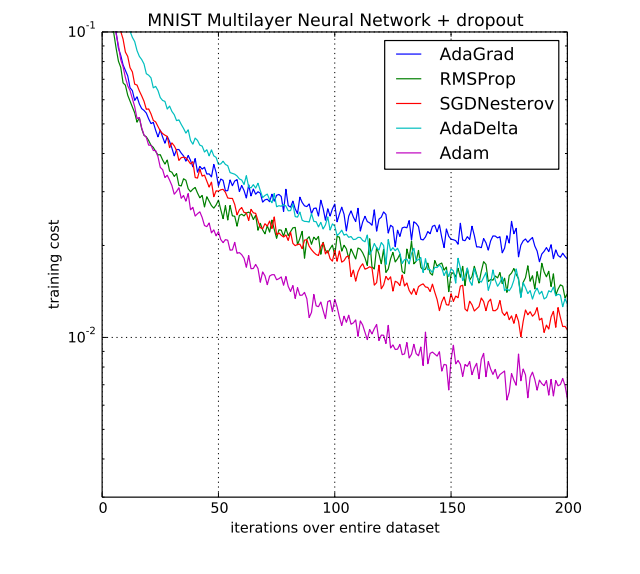

### Train our model

In [ ]:
history = model.fit(train_images, train_labels, epochs=7, callbacks=[tensorboard_callback], 
                    validation_data=(test_images, test_labels))

### View Architecture of Model via Tensorboard

In [ ]:
#%tensorboard --logdir logs   # magic command - Magics are specific to and provided by the IPython kernel.

### Evaluate the model

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
#print(test_acc)

### Predict the class a single image should be in

In [ ]:
predictions = model.predict(test_images)

In [ ]:
predictions[0]

In [ ]:
np.argmax(predictions[0])

In [ ]:
class_names[]

In [ ]:
plt.imshow(test_images[0])